In [ ]:
import os

os.environ['CUPY_TF32'] = "1"
os.environ['CUPY_ACCELERATORS'] = "cub,cutensor"

import numpy as np

import cupy
from cupy.cuda import cublas

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from activations import SiLU, SoftMax
from layers import TransformerBlock, LayerNorm, Convolution, Flatten, MaxPool, Dense, Dropout
from network import Network, CrossEntropy
from transformer_adapters import VitProjector, VitMLPHead, GPTEmbedFront, GPTEmbedBack
from utils import *

cublas_handle = cupy.cuda.Device().cublas_handle
cublas.setMathMode(cublas_handle, cublas.CUBLAS_TENSOR_OP_MATH)

In [ ]:
def load_batch(batch_path):
    with open(batch_path, 'rb') as f:
        dct = pickle.load(f, encoding='latin1')
    data = dct['data']
    labels = np.array(dct['labels'])
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels


def load_cifar10(root = "datasets/cifar-10-batches-py/"):
    x_train = []
    y_train = []

    for i in range(1, 6):
        data, labels = load_batch(os.path.join(root, f"data_batch_{i}"))
        x_train.append(data)
        y_train.append(labels)

    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    x_test, y_test = load_batch(os.path.join(root, "test_batch"))

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = load_cifar10()

x_train = (x_train / 255).astype(np.float32)
x_test  = (x_test / 255).astype(np.float32)

In [ ]:
model = Network(
    [
        Convolution((32,32,3), (3,3), 16),
        MaxPool(2,2),
        SiLU(),

        Convolution((15,15,16), (4,4), 32),
        MaxPool(2,2),
        SiLU(),

        Flatten(),
        Dropout(0.25),

        Dense(1152,128),
        SiLU(),
        Dropout(0.25),

        Dense(128, 10),
        SoftMax()
    ]
)

criterion = CrossEntropy(10)

In [ ]:
print("Training:")
model.set_eval(False)
model.train(x_train, y_train, criterion, epochs = 10, learning_rate = .001, batch_size = 128, weight_decay = 0.01)

print("Testing:")
model.set_eval(True)
loss, accuracy = model.evaluate(x_test, y_test, criterion, batch_size = 256)
print(f"Loss: {loss}, Accuracy: {accuracy}")

In [ ]:
# some crude image augments
x_train = np.concatenate([x_train, np.flip(x_train, axis = 2)])
x_train = np.concatenate([x_train, np.roll(x_train, 1,  axis = 1),
                                   np.roll(x_train, -1, axis = 1),
                                   np.roll(x_train, 1,  axis = 2),
                                   np.roll(x_train, -1, axis = 2),])

y_train = np.array(y_train)

y_train = np.concatenate([y_train, y_train])
y_train = np.concatenate([y_train, y_train, y_train, y_train, y_train])

shuffle = np.random.permutation(len(x_train))

x_train = x_train[shuffle]
y_train = y_train[shuffle].reshape(-1)

x_test = cupy.array((x_test / 255.0), dtype = np.float32)
y_test = cupy.array(y_test).reshape(-1)

embed_size = 512
num_heads = 8
num_latents = 15 # 64 + 1 + 15 = 80 tokens
dropout_rate = 0.5

model = Network(
    [
        VitProjector((32, 32, 3), (4, 4), embed_size, num_latents=num_latents),

        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),
        TransformerBlock(embed_size, 0, num_heads, SiLU(), dropout_rate = dropout_rate),

        LayerNorm(embed_size),
        VitMLPHead(embed_size, 10),
        SoftMax()
    ]
)

criterion = CrossEntropy(10)

In [ ]:
print("Training:")
model.set_eval(False)
model.train(x_train, y_train, criterion, epochs = 5, learning_rate = .001, batch_size = 128, weight_decay = 0.01)

print("Testing:")
model.set_eval(True)
loss, accuracy = model.evaluate(x_test, y_test, criterion, batch_size = 256)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Training:


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


epoch: 1 loss: 2.2365005 accuracy: 0.2266 



100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


epoch: 2 loss: 1.8482525 accuracy: 0.3342 



100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


epoch: 3 loss: 1.7284489 accuracy: 0.3749 



100%|██████████| 391/391 [00:39<00:00,  9.89it/s]


epoch: 4 loss: 1.6710211 accuracy: 0.39766 



100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


epoch: 5 loss: 1.6254866 accuracy: 0.41306 

Testing:


100%|██████████| 40/40 [00:01<00:00, 20.83it/s]

Loss: 1.5643237829208374, Accuracy: 0.4312


In [ ]:
# Adapted from Andrej Karpathy's GPT Tutorial: https://github.com/karpathy/ng-video-lecture

text = None
with open('datasets/lotr.txt') as handle:
    text = handle.read()

chars = sorted(list(set(text)))

vocab_size = len(chars) #64 for shakespeare 80 for tolkien
embed_size = 512
num_heads = 8
context_length = 1024


learning_rate = 0.0003
batch_size = 16
dropout_rate = 0.25


# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

tokens = np.array(encode(text), dtype=np.uint8)
arr = []
for i in range(len(tokens) - context_length + 1):
  arr.append(tokens[i:i+context_length])

arr = np.array(arr, dtype=np.uint8)

data = arr[:-1]
labels = arr[1:]

shuffle = np.random.permutation(len(data))

data = data[shuffle]
labels = labels[shuffle]
print(data.shape, data.dtype, labels.shape, labels.dtype)

(3086379, 1024) uint8 (3086379, 1024) uint8


In [ ]:
class GPT:
    def __init__(self):
        self.embedding_table = init_random_tensor(size = (vocab_size, embed_size))
        self.model = Network(
            [
                GPTEmbedFront(self.embedding_table, context_length),

                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),
                TransformerBlock(embed_size, context_length, num_heads, SiLU(), decoder = True, dropout_rate=dropout_rate),

                GPTEmbedBack(self.embedding_table),
                SoftMax()
            ],
        )
        self.criterion = CrossEntropy(num_classes = vocab_size)


    def train(self, epochs = 1):

      x = data
      y = labels

      self.model.train(x, y, self.criterion, epochs = epochs, learning_rate = learning_rate, batch_size = batch_size)

    def generate(self, length, seed = " "):

          print(seed, end = "")

          tokens = cupy.array(encode(seed), dtype = cupy.uint8).reshape((1, len(seed)))

          for i in range(length):

            tokens = tokens[:,max(0, len(tokens[0]) - context_length):]

            probs = self.model.predict(tokens)[0, -1]
            out = cupy.random.choice(cupy.arange(0, vocab_size, dtype = cupy.uint8), size = (1,1), p = probs)

            tokens = cupy.concatenate((tokens, out), axis = 1)

            print(itos[int(out[0,0].get())], end = "")

gpt = GPT()


In [8]:
gpt.model.predict(data[:batch_size])
for layer in gpt.model.layers:
  print("Input Type:", layer.input.dtype, "Layer:", type(layer), "Output Type:", layer.output.dtype)

Input Type: uint8 Layer: <class 'transformer_adapters.GPTEmbedFront'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'layers.TransformerBlock'> Output Type: float32
Input Type: float32 Layer: <class 'transformer_adapters.GPTEmbedBack'> Output Type: float32
Input Type: float32 Layer: <class 'activations.SoftMax'> Output Type: float32


In [9]:
gpt.train()

 21%|██        | 40301/192899 [2:39:17<10:03:10,  4.22it/s]


KeyboardInterrupt: 

In [28]:
gpt.model.set_eval(True)
gpt.model.layers[-1].temperature = 1.0
gpt.generate(1024, "Aragorn")

Aragorn. 'I understand three times Faramir, 

 Many that garden long ago,' said Faramir came. 'Cannot be merry tirthday, 
and no row or bear of it. I wish I had fallen inside there my help me.' 
 'Is it enough that I was him?' said the cast. 'I was crowned with I 
who do not believe that there was to be seen on the road before my 
country. In the deep I came I was with Ithilien; but I found myself too 
true to tried and put a good pen to the war in the water again over the 
turf pells. It seemed to be no more than my words. For the Arfore could see 
nothing for them in this would have nothing in this mind and that hour, and 
more than a crowd in the dim light of day. 
 'Come!' cried Frodo, springing to his feet. 'Is it not a part of back? 
Iwork it will be assailing?' 
 'I will,' said Frodo suddenly, coming forward. 'It is an eagle, but I 
have seen far away by rear. The fool's now iss. How long it yet. no bring 
without war none.' 
 'It's time we go to think of something,' said Farami

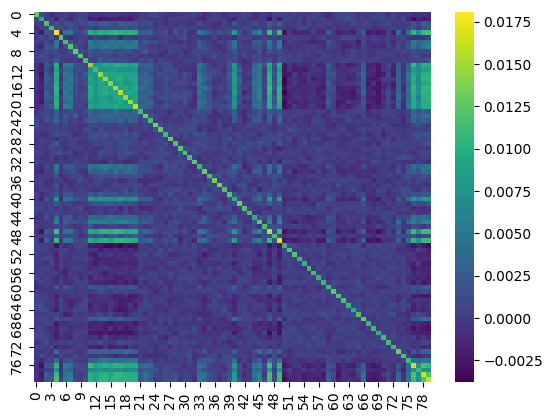

In [ ]:
# Visualize token dot product similarities
similarities = (gpt.embedding_table @ gpt.embedding_table.transpose()).get()

similarities /= np.linalg.trace(similarities)

sns.heatmap(similarities, cmap = "viridis")
plt.show()

In [ ]:
path = "/content/drive/MyDrive/ai-models/"

def save_weights(model, path):

  lst = []

  for layer in model.layers:

    dct = {
        "name": type(layer).__name__,
        "parameters": []
    }

    for parameter in layer.parameters:
      dct["parameters"].append(parameter.get())
    lst.append(dct)

  with open(path, "wb") as handle:
    pickle.dump(lst, handle)


def load_weights(model, path):

  model._zero_grad()

  lst = []

  with open(path, "rb") as handle:
    lst = pickle.load(handle)

  for layer, dct in zip(model.layers, lst):
    for parameter, arr in zip(layer.parameters, dct["parameters"]):
      parameter *= 0
      parameter += cupy.array(arr, dtype = cupy.float32)



In [ ]:
save_weights(gpt.model, path + "my_lotr_gpt_1024.pkl")

In [35]:
load_weights(gpt.model, path + "my_lotr_gpt_1024.pkl")